In [10]:
import os
import numpy as np
import pandas as pd

import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
from torchvision import models, transforms, datasets
from torchvision.transforms import ToTensor

from torch.utils.tensorboard import SummaryWriter


In [11]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [12]:
# Thư mục chứa dataset
data_dir = r"C:\Users\Nguyen Trung An\Downloads\DL_Practice-dong (1)\DL_Practice-dong\practice2\flowers"

# Chuẩn hóa theo ImageNet
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.299, 0.224, 0.225)

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Tạo dataset chính
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Chia thành train / val / test
train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset))
val_size = len(dataset) - train_size - test_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Gán transform test cho val và test
val_data.dataset.transform = test_transform
test_data.dataset.transform = test_transform

# DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

print("✅ Dataloader created successfully!")


✅ Dataloader created successfully!


In [13]:
print(f"Tổng số ảnh trong dataset: {len(dataset)}")
print(f"Các lớp: {dataset.classes}")


Tổng số ảnh trong dataset: 4317
Các lớp: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [14]:
model = models.resnet18(weights="IMAGENET1K_V1")

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)


In [15]:
num_epochs = 10

for epoch in range(num_epochs):
    print(f"\n🔹 Epoch {epoch+1}/{num_epochs}")
    model.train()
    train_loss, train_correct = 0.0, 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")



🔹 Epoch 1/10


Train Loss: 1.0473 | Train Acc: 0.6253
Val   Loss: 0.6526 | Val   Acc: 0.8120

🔹 Epoch 2/10


Train Loss: 0.5789 | Train Acc: 0.8176
Val   Loss: 0.4893 | Val   Acc: 0.8552

🔹 Epoch 3/10


Train Loss: 0.4670 | Train Acc: 0.8577
Val   Loss: 0.4279 | Val   Acc: 0.8675

🔹 Epoch 4/10


Train Loss: 0.4058 | Train Acc: 0.8696
Val   Loss: 0.3788 | Val   Acc: 0.8690

🔹 Epoch 5/10


Train Loss: 0.3789 | Train Acc: 0.8798
Val   Loss: 0.3602 | Val   Acc: 0.8875

🔹 Epoch 6/10


Train Loss: 0.3571 | Train Acc: 0.8845
Val   Loss: 0.3538 | Val   Acc: 0.8783

🔹 Epoch 7/10


Train Loss: 0.3345 | Train Acc: 0.8934
Val   Loss: 0.3386 | Val   Acc: 0.8844

🔹 Epoch 8/10


Train Loss: 0.3174 | Train Acc: 0.8947
Val   Loss: 0.3236 | Val   Acc: 0.8875

🔹 Epoch 9/10


Train Loss: 0.3089 | Train Acc: 0.8964
Val   Loss: 0.3255 | Val   Acc: 0.8875

🔹 Epoch 10/10


Train Loss: 0.2981 | Train Acc: 0.9040
Val   Loss: 0.2886 | Val   Acc: 0.8983


In [23]:
#optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)


In [24]:
#Tensor board
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/flower_exp_1')

In [25]:
from tqdm import tqdm

def train_loop(dataloader, model, loss_fn, optimizer, epoch, writer, device):
    model.train()
    running_loss, running_correct = 0.0, 0
    total_samples = len(dataloader.dataset)

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Training]", leave=False)

    for batch_idx, (X, y) in enumerate(progress_bar):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        # Cập nhật thống kê
        running_loss += loss.item() * X.size(0)
        preds = outputs.argmax(1)
        running_correct += (preds == y).sum().item()

        # Log từng batch
        global_step = epoch * len(dataloader) + batch_idx
        batch_acc = 100.0 * (preds == y).sum().item() / X.size(0)
        writer.add_scalar("Train/Loss_batch", loss.item(), global_step)
        writer.add_scalar("Train/Acc_batch", batch_acc, global_step)

        # Cập nhật thanh tiến trình
        progress_bar.set_postfix(loss=loss.item(), acc=batch_acc)

    # Tính kết quả epoch
    epoch_loss = running_loss / total_samples
    epoch_acc = 100.0 * running_correct / total_samples

    # Log trung bình epoch
    writer.add_scalar("Train/Loss_epoch", epoch_loss, epoch)
    writer.add_scalar("Train/Acc_epoch", epoch_acc, epoch)

    # Log histogram trọng số (để xem sự thay đổi tham số)
    for name, param in model.named_parameters():
        if param.requires_grad:
            writer.add_histogram(f"Weights/{name}", param.detach().cpu(), epoch)

    return epoch_loss, epoch_acc


In [26]:
from tqdm import tqdm
import torch

# -------------------------------
# 🔹 Validation Loop
# -------------------------------
def val_loop(dataloader, model, loss_fn, epoch, writer, device):
    model.eval()
    val_loss, correct = 0.0, 0
    total_samples = len(dataloader.dataset)

    with torch.no_grad():
        for X, y in tqdm(dataloader, desc=f"Validation Epoch {epoch+1}", leave=False):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            val_loss += loss_fn(outputs, y).item() * X.size(0)
            preds = outputs.argmax(1)
            correct += (preds == y).sum().item()

    # Trung bình loss & tính độ chính xác
    val_loss /= total_samples
    val_acc = 100.0 * correct / total_samples

    # Ghi log TensorBoard
    writer.add_scalar("Val/Loss_epoch", val_loss, epoch)
    writer.add_scalar("Val/Accuracy_epoch", val_acc, epoch)

    return val_loss, val_acc

In [27]:
from tqdm import tqdm

def test_loop(dataloader, model, loss_fn, writer, device):
    model.eval()
    test_loss, correct = 0.0, 0
    total_samples = len(dataloader.dataset)
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Testing", leave=False):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            test_loss += loss_fn(outputs, y).item()
            preds = outputs.argmax(1)
            correct += (preds == y).sum().item()

    test_loss /= num_batches
    test_acc = 100.0 * correct / total_samples

    print(f"\n📊 Test Results:\n Accuracy: {test_acc:.2f}% | Avg Loss: {test_loss:.6f}")

    # Log TensorBoard
    writer.add_scalar("Test/Loss", test_loss)
    writer.add_scalar("Test/Accuracy", test_acc)

    return test_loss, test_acc

In [30]:
from torch.utils.tensorboard import SummaryWriter
import torch

# Khởi tạo TensorBoard writer
writer = SummaryWriter('runs/flower_classifier')

EPOCHS = 10
best_val_acc = 0.0
best_model_path = "best_flower_classifier.pth"

print("🚀 Bắt đầu huấn luyện mô hình ResNet18 trên tập dữ liệu hoa...\n")

for epoch in range(EPOCHS):
    print(f"🌸 Epoch {epoch+1}/{EPOCHS}")
    print("-------------------------------")

    # 🔹 Huấn luyện (truyền thêm device)
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer, epoch, writer, device)

    # 🔹 Đánh giá (validation)
    val_loss, val_acc = val_loop(val_loader, model, loss_fn, epoch, writer, device)

    # In kết quả Epoch
    print(f"📘 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"📗 Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")

    # Lưu model nếu tốt hơn
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Model improved! Saved new best model (Val Acc = {val_acc:.2f}%)")

    print()

writer.close()
print(f"🎉 Training complete! Best model saved at '{best_model_path}' with Val Acc = {best_val_acc:.2f}%")

# ===================================================
# 🔹 Đánh giá mô hình tốt nhất trên tập test
# ===================================================
print("\n🔍 Loading best model for final evaluation...")
model.load_state_dict(torch.load(best_model_path, map_location=device))

test_loss, test_acc = test_loop(test_loader, model, loss_fn, writer, device)
print(f"🏁 Final Test Accuracy: {test_acc:.2f}% | Test Loss: {test_loss:.4f}")


🚀 Bắt đầu huấn luyện mô hình ResNet18 trên tập dữ liệu hoa...

🌸 Epoch 1/10
-------------------------------


📘 Train Loss: 0.2941 | Train Acc: 89.61%
📗 Val   Loss: 0.2950 | Val   Acc: 89.68%
✅ Model improved! Saved new best model (Val Acc = 89.68%)

🌸 Epoch 2/10
-------------------------------


📘 Train Loss: 0.2773 | Train Acc: 90.50%
📗 Val   Loss: 0.3066 | Val   Acc: 88.75%

🌸 Epoch 3/10
-------------------------------


📘 Train Loss: 0.2671 | Train Acc: 90.47%
📗 Val   Loss: 0.2846 | Val   Acc: 90.60%
✅ Model improved! Saved new best model (Val Acc = 90.60%)

🌸 Epoch 4/10
-------------------------------


📘 Train Loss: 0.2551 | Train Acc: 90.93%
📗 Val   Loss: 0.2792 | Val   Acc: 90.14%

🌸 Epoch 5/10
-------------------------------


📘 Train Loss: 0.2646 | Train Acc: 91.00%
📗 Val   Loss: 0.2709 | Val   Acc: 90.45%

🌸 Epoch 6/10
-------------------------------


📘 Train Loss: 0.2429 | Train Acc: 91.46%
📗 Val   Loss: 0.2802 | Val   Acc: 89.68%

🌸 Epoch 7/10
-------------------------------


📘 Train Loss: 0.2445 | Train Acc: 91.72%
📗 Val   Loss: 0.2636 | Val   Acc: 89.98%

🌸 Epoch 8/10
-------------------------------


📘 Train Loss: 0.2419 | Train Acc: 91.10%
📗 Val   Loss: 0.2670 | Val   Acc: 90.29%

🌸 Epoch 9/10
-------------------------------


📘 Train Loss: 0.2307 | Train Acc: 91.99%
📗 Val   Loss: 0.2754 | Val   Acc: 89.06%

🌸 Epoch 10/10
-------------------------------


📘 Train Loss: 0.2257 | Train Acc: 91.86%
📗 Val   Loss: 0.2628 | Val   Acc: 90.45%

🎉 Training complete! Best model saved at 'best_flower_classifier.pth' with Val Acc = 90.60%

🔍 Loading best model for final evaluation...



📊 Test Results:
 Accuracy: 88.41% | Avg Loss: 0.353081
🏁 Final Test Accuracy: 88.41% | Test Loss: 0.3531


In [31]:
model.load_state_dict(torch.load(best_model_path, map_location=device))

print("\n🔍 Evaluating on test set...")
test_loss, test_acc = test_loop(test_loader, model, loss_fn, writer, device)
print(f"🏁 Final Test Accuracy: {test_acc:.2f}% | Test Loss: {test_loss:.4f}")



🔍 Evaluating on test set...



📊 Test Results:
 Accuracy: 88.41% | Avg Loss: 0.353081
🏁 Final Test Accuracy: 88.41% | Test Loss: 0.3531


In [32]:
# Load best model
model.load_state_dict(torch.load("best_flower_classifier.pth", map_location=device))
model.to(device)
print("✅ Best model loaded successfully!")

# Evaluate on test set
print("\n🔍 Evaluating on test set...")
test_loss, test_acc = test_loop(test_loader, model, loss_fn, writer, device)
print(f"🏁 Final Test Accuracy: {test_acc:.2f}% | Test Loss: {test_loss:.4f}")


✅ Best model loaded successfully!

🔍 Evaluating on test set...



📊 Test Results:
 Accuracy: 88.41% | Avg Loss: 0.353081
🏁 Final Test Accuracy: 88.41% | Test Loss: 0.3531


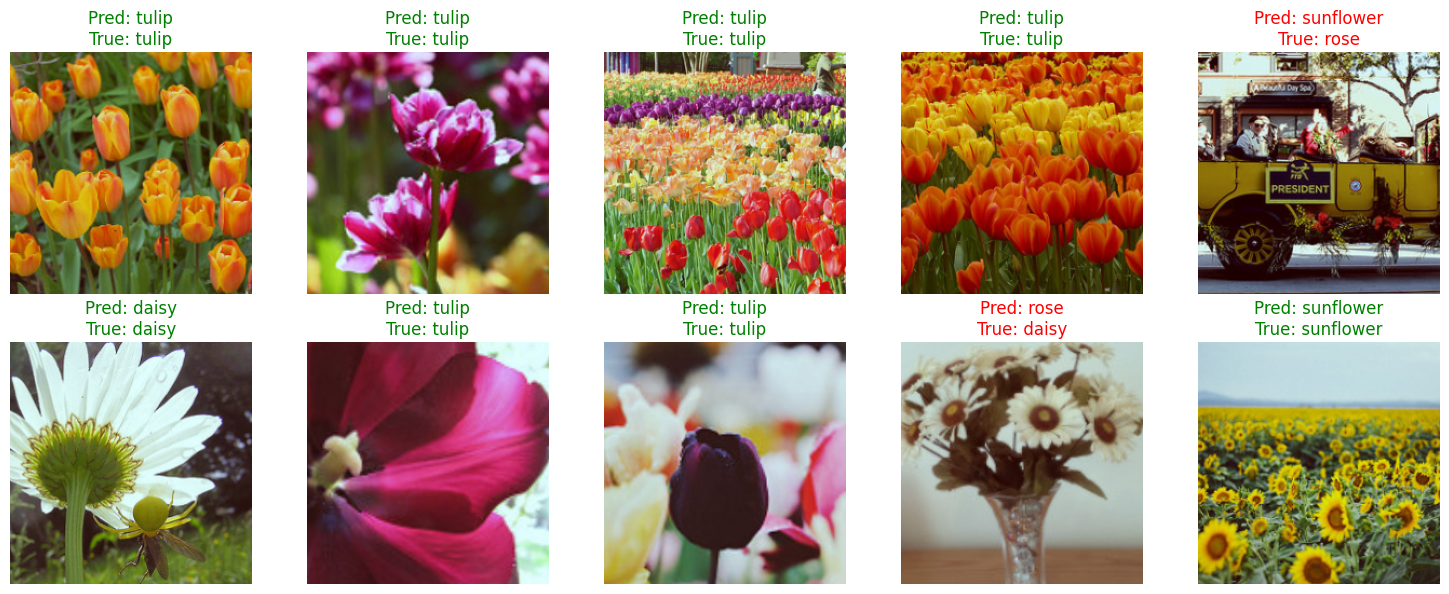

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# ===== Load dataset để lấy class names =====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(
    root=r"C:\Users\Nguyen Trung An\Downloads\DL_Practice-dong (1)\DL_Practice-dong\practice2\flowers",
    transform=train_transforms
)
class_names = full_dataset.classes

# ===== Hàm hiển thị ảnh =====
def imshow(img, ax):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    ax.imshow(img)

# ===== Random 10 ảnh từ test dataset =====
test_dataset = test_loader.dataset
indices = np.random.choice(len(test_dataset), size=10, replace=False)

images = []
labels = []
for idx in indices:
    img, label = test_dataset[idx]
    images.append(img)
    labels.append(label)

images = torch.stack(images).to(device)
labels = torch.tensor(labels)

# ===== Dự đoán =====
model.to(device)
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# ===== Hiển thị ảnh và kết quả =====
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    ax = axes[i]
    imshow(images[i], ax)
    true_label = class_names[labels[i].item()]
    pred_label = class_names[preds[i].item()]
    color = "green" if true_label == pred_label else "red"
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [37]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Đưa model sang eval
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tạo confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Chuẩn hóa theo hàng

# ✅ Lấy class names từ test_loader
class_names = test_loader.dataset.classes

# In classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Vẽ Confusion Matrix bằng Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix - Flower Recognition")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'sklearn'